In [131]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot
from tqdm import tqdm

from keras.datasets import mnist




In [132]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [133]:
print('X_train: ' , train_X.shape)
print('Y_train: ', (train_y.shape))
print('X_test:  ', (test_X.shape))
print('Y_test:  ', test_y.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


# DataLoader

In [134]:
class MNIST(Dataset):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    
    

In [135]:
train_dl = DataLoader(MNIST(train_X, train_y), batch_size=256)
test_dl = DataLoader(MNIST(test_X, test_y), batch_size= 64)

# Criando o Modelo


Irei pegar cada dado, transformar o tensor em um tensor de 1 dimensão e depois aplicar o Linear interpolado por Relu. Já Na saída vou pegar os dados do Linear e sair 10 resultados (0,1,2,3,4...8,9)

In [136]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model,self).__init__()

        
        self.A1 = nn.Flatten()
        self.L1 = nn.Linear(28*28,20)
        self.A2 = nn.ReLU()
        self.L2 = nn.Linear(20,10)
        
        

        
    def forward(self, x):
        
        x = self.A1(x)
        x = self.L1(x)
        x = self.A2(x)
        x = self.L2(x)
        
        
        return x

    

In [137]:
#for xb, yb in train_dl:
#    for i in range(9):  
#        pyplot.subplot(330 + 1 + i)
#        pyplot.imshow(xb[i], cmap=pyplot.get_cmap('gray'))
#        pyplot.show()

In [138]:
weights_L1_b = MLP_Model().L1.weight.round(decimals=2).detach()

In [139]:
L1_value_before_train = torch.histogram(weights_L1_b)

X_L1_before = L1_value_before_train[1][0:100]
y_L1_before = L1_value_before_train[0]



# Train

In [140]:
def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
            
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        
        #print(epoch, "loss=", loss.item())
        loss_list.append(loss.item())
            
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    
    
    return MLP_Model().L1.weight.detach()
    

100%|██████████| 51/51 [00:42<00:00,  1.19it/s]


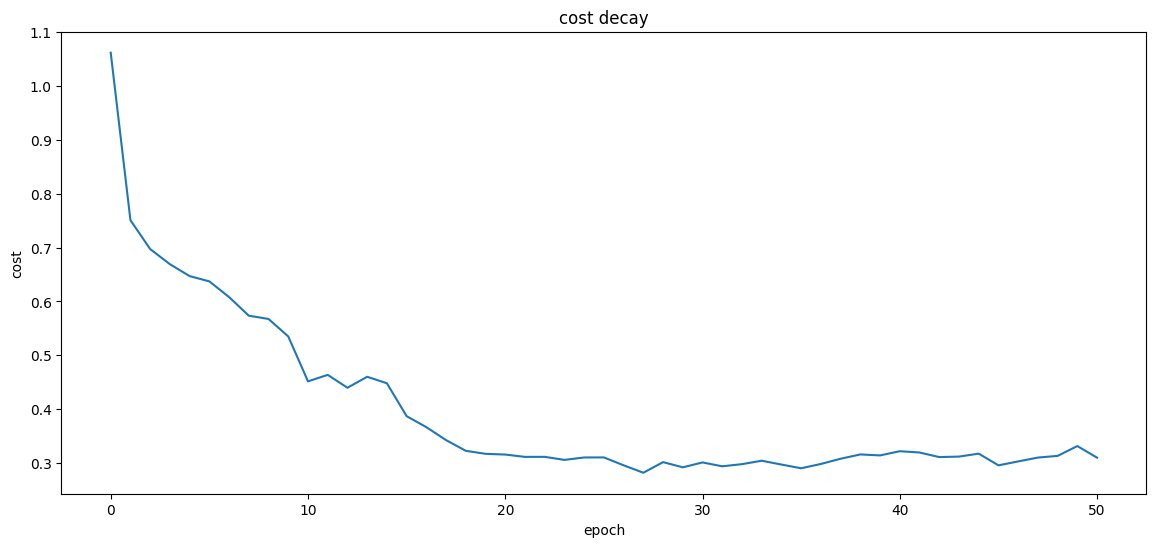

In [141]:
model = MLP_Model()

epochs = 50

opt        = torch.optim.Adam( model.parameters(), lr=0.003 )

loss_fn    = nn.CrossEntropyLoss()   

weights_L1_a = training(  epochs, model , loss_fn, opt  )


In [142]:
#model = torch.load("MLP_Model.pt")

# Evaluation

In [143]:
# lambda function, 
# model.predict = lambda x : nn.Softmax()(model.net(x))
        

In [144]:
with torch.no_grad():
    
    model.eval()
    
    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)
        
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
  
    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))        
    
 


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       980
           1       0.95      0.98      0.96      1135
           2       0.89      0.78      0.84      1032
           3       0.92      0.61      0.74      1010
           4       0.78      0.90      0.84       982
           5       0.62      0.87      0.73       892
           6       0.90      0.90      0.90       958
           7       0.97      0.79      0.87      1028
           8       0.63      0.72      0.67       974
           9       0.82      0.74      0.78      1009

    accuracy                           0.82     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.82      0.83     10000



# Histogramas

Layer 1


In [170]:
L1_value_after_train = torch.histogram(weights_L1_a.flatten().round(decimals=4))

X_L1_after = L1_value_after_train[1][0:100]
y_L1_after = L1_value_after_train[0]


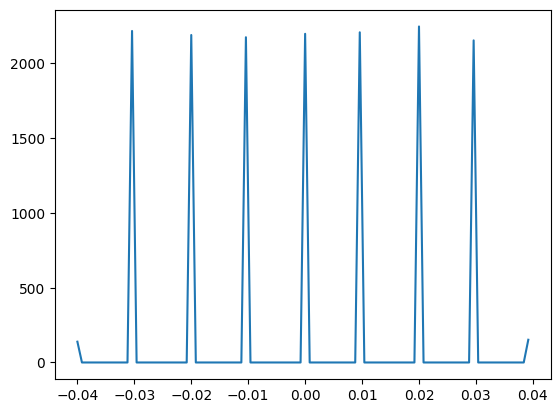

In [151]:
hist_before_train = plt.plot(X_L1_before,y_L1_before)

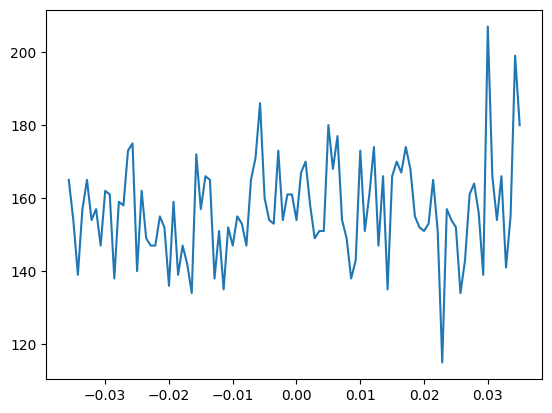

In [171]:
hist_after_train = plt.plot(X_L1_after,y_L1_after)

# Rede Convulucional